In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('plotting.mplstyle')
import json
import numpy as np
np.random.seed(150914)
from scipy.special import gamma,erf
from scipy.stats import gaussian_kde

**Warning**: This script assumes that you have cloned the repository hosting data for Galaudage+ 2021 (ApJL 921, L15): https://github.com/shanikagalaudage/bbh_spin


Specifically, it assumes that a link to this repository has been created in the following location:

```bash
../code/input/galaudage-data
```

If you have *not* cloned this repository, do the following (replace brackets with actual filepaths):

```bash
$ cd [...desired location...]
$ git clone git@github.com:shanikagalaudage/bbh_spin.git
$ cd [...gwtc3-spin-studies repository]/code/input/
$ ln -s [...path to bbh_spin] galaudage-data
```

In [2]:
# Load Galaudage+ hyperposterior samples
extendedFile = "../code/input/galaudage-data/hyperposterior_samples/mass-powerlawpeak_spin-extended_redshift-powerlaw.json"
with open(extendedFile,'r') as jf:
    extendedData = json.load(jf)
extendedPosterior = extendedData['posterior']['content']

# Read component spin mean and variances
mu_chis = np.array(extendedPosterior['mu_chi'])
var_chis = np.array(extendedPosterior['sigma_chi'])

# Compute the implied beta distribution shape parameters
alphas = mu_chis**2*(1.-mu_chis)/var_chis - mu_chis
betas = mu_chis*(1.-mu_chis)**2/var_chis - (1.-mu_chis)

# Compute appropriate normalization factors for beta distribution
# Note that some of the alpha values are large enough that scipy's gamma function overflows,
# causing the `RuntimeWarning` that appears below.
# We will remove these samples; this removes roughly 1% of samples
B_norms = gamma(alphas)*gamma(betas)/gamma(alphas+betas)
badInds = (B_norms!=B_norms)
goodInds = (B_norms==B_norms)*(B_norms>0)

print("{0} samples removed of {1} total".format(B_norms[badInds].size,B_norms.size))

95 samples removed of 10174 total


/var/folders/x_/s7xg857s2pvf17c6fbc0r7b40001g6/T/ipykernel_78367/2822138889.py:19: RuntimeWarning: overflow encountered in multiply
  B_norms = gamma(alphas)*gamma(betas)/gamma(alphas+betas)
/var/folders/x_/s7xg857s2pvf17c6fbc0r7b40001g6/T/ipykernel_78367/2822138889.py:19: RuntimeWarning: invalid value encountered in true_divide
  B_norms = gamma(alphas)*gamma(betas)/gamma(alphas+betas)


In [3]:
# Build up distributions of effective spin implied by the Galaudage+ "Extended" results
# Specify number of distributions to build and number of individual spins to draw per distribution
nDraws = 1000
nSpinsPerDraw = 5000
nSamps = len(np.array(extendedPosterior['alpha'])[goodInds])

# Set up arrays to hold drawn individual event properties
qs = np.zeros((nDraws,nSpinsPerDraw))
chi_1s = np.zeros((nDraws,nSpinsPerDraw))
chi_2s = np.zeros((nDraws,nSpinsPerDraw))
cost_1s = np.zeros((nDraws,nSpinsPerDraw))
cost_2s = np.zeros((nDraws,nSpinsPerDraw))

# Loop over requested number of distributions
for i in range(nDraws):
    
    # Choose a random population parameter
    pop_ind = np.random.choice(np.arange(nSamps))
    mu_chi = np.array(extendedPosterior['mu_chi'])[goodInds][pop_ind]
    var_chi = np.array(extendedPosterior['sigma_chi'])[goodInds][pop_ind]
    zeta_spike = np.array(extendedPosterior['lambda_chi_peak'])[goodInds][pop_ind]
    xi_spin = np.array(extendedPosterior['xi_spin'])[goodInds][pop_ind]
    zmin = np.array(extendedPosterior['zmin'])[goodInds][pop_ind]
    sigma_spin = np.array(extendedPosterior['sigma_spin'])[goodInds][pop_ind]
    
    # Compute shape parameters for beta distributions
    alpha = mu_chi**2*(1.-mu_chi)/var_chi - mu_chi
    beta = mu_chi*(1.-mu_chi)**2/var_chi - (1.-mu_chi)
    
    # Draw a set of random numbers determining if component spins are in the zero-spin spike or bulk
    mag_test = np.random.random(nSpinsPerDraw)
    chi_1s[i,mag_test<zeta_spike] = 0.
    chi_2s[i,mag_test<zeta_spike] = 0.
    chi_1s[i,mag_test>=zeta_spike] = np.random.beta(alpha,beta,size=np.count_nonzero(mag_test>=zeta_spike))
    chi_2s[i,mag_test>=zeta_spike] = np.random.beta(alpha,beta,size=np.count_nonzero(mag_test>=zeta_spike))
    
    # Draw random number assigning spin1's to the isotropic or aligned component
    tilt1_test = np.random.random(nSpinsPerDraw)
    
    # For spins in isotropic component, set random cos(t) values
    cost_1s[i,tilt1_test>=xi_spin] = np.random.random(np.count_nonzero(tilt1_test>=xi_spin))*(1.-zmin) + zmin
    
    # For those in aligned, initialize to unphysical values, then draw new values from an aligned
    # Gaussian until a physical value is found
    cost_1s[i,tilt1_test<xi_spin] = -10
    while np.any(cost_1s[i,:]>1) or np.any(cost_1s[i,:]<zmin):
        to_replace = (cost_1s[i,:]>1) + (cost_1s[i,:]<zmin)
        cost_1s[i,to_replace] = np.random.normal(loc=1,scale=sigma_spin,size=np.count_nonzero(to_replace))
     
    # Repeat with spin2
    tilt2_test = np.random.random(nSpinsPerDraw)
    cost_2s[i,tilt2_test>=xi_spin] = np.random.random(np.count_nonzero(tilt2_test>=xi_spin))*(1.-zmin) + zmin
    cost_2s[i,tilt2_test<xi_spin] = -10
    while np.any(cost_2s[i,:]>1) or np.any(cost_2s[i,:]<zmin):
        to_replace = (cost_2s[i,:]>1) + (cost_2s[i,:]<zmin)
        cost_2s[i,to_replace] = np.random.normal(loc=1,scale=sigma_spin,size=np.count_nonzero(to_replace))    
        
    # Also get mass parameters (we'll need this to draw mass ratios)
    mMin = np.array(extendedPosterior['mmin'])[goodInds][pop_ind]
    mMax = np.array(extendedPosterior['mmax'])[goodInds][pop_ind]
    m1_alpha = -np.array(extendedPosterior['alpha'])[goodInds][pop_ind]
    m1_mu = np.array(extendedPosterior['mpp'])[goodInds][pop_ind]
    m1_sig = np.array(extendedPosterior['sigpp'])[goodInds][pop_ind]
    m1_fPeak = np.array(extendedPosterior['lam'])[goodInds][pop_ind]
    m2_beta = np.array(extendedPosterior['beta'])[goodInds][pop_ind]
    delta_m = np.array(extendedPosterior['delta_m'])[goodInds][pop_ind]
    
    # The CDF of the primary mass distribution isn't analytic, so we'll need to build p(m1) and
    # numerically construct a CDF in order to draw m1 samples
    # First compute and combine the "Power Law" and "Peak" parts of the "PowerLaw+Peak" model
    m1_grid = np.linspace(mMin-1.,mMax+1.,1000)
    p_m1_gaussian = np.exp(-(m1_grid-m1_mu)**2/(2.*m1_sig**2))/np.sqrt(2.*np.pi*m1_sig**2)
    p_m1_powerLaw = (1.+m1_alpha)*m1_grid**m1_alpha/(mMax**(1.+m1_alpha) - mMin**(1.+m1_alpha))
    p_m1 = (1.-m1_fPeak)*p_m1_powerLaw + m1_fPeak*p_m1_gaussian
    
    # Now we need to compute and apply a tapering function that turns on at mMin
    smoothing = np.ones_like(m1_grid)
    smoothing[m1_grid<mMin] = 0
    to_smooth = (m1_grid>=mMin)*(m1_grid<mMin+delta_m)
    smoothing[to_smooth] = (np.exp(delta_m/(m1_grid[to_smooth]-mMin) + delta_m/(m1_grid[to_smooth]-mMin-delta_m)) + 1)**(-1.)

    # For m1_grid values sufficiently close to mMin, the exponential in the above line will overflow.
    # Override these to zero, since the smoothing function is effective sending these points arbitrarily
    # close to zero anyway
    smoothing[smoothing!=smoothing] = 0
    p_m1 *= smoothing
    
    # Numerically compute CDF
    # Draw random cdf values and find the corresonding m1s
    cdf_m1 = np.cumsum(p_m1)/np.sum(p_m1)
    cs = np.random.random(nSpinsPerDraw)
    m1s = np.interp(cs,cdf_m1,m1_grid)
    
    # To draw m2, we need to similarly construct a CDF numerically
    m2s = np.zeros(nSpinsPerDraw)
    for ii in range(nSpinsPerDraw):
    
        # Power law
        m2_grid = np.linspace(mMin-1.,m1s[ii]+1.,1000)
        p_m2 = (1.+m2_beta)*m2_grid**m2_beta/(m1s[ii]**(1.+m2_beta) - mMin**(1.+m2_beta))
        
        # Apply smoothing
        smoothing = np.ones_like(m2_grid)
        smoothing[m2_grid<mMin] = 0
        to_smooth = (m2_grid>=mMin)*(m2_grid<mMin+delta_m)
        smoothing[to_smooth] = (np.exp(delta_m/(m2_grid[to_smooth]-mMin) + delta_m/(m2_grid[to_smooth]-mMin-delta_m)) + 1)**(-1.)
        smoothing[smoothing!=smoothing] = 0
        p_m2 *= smoothing
        
        # Numerically compute CDF
        # Draw random cdf values and find the corresonding m2
        cdf_m2 = np.cumsum(p_m2)/np.sum(p_m2)
        cs = np.random.random()
        m2s[ii] = np.interp(cs,cdf_m2,m2_grid)    
        
    # Phew. We can finally compute mass ratios
    qs[i,:] = m2s/m1s

/var/folders/x_/s7xg857s2pvf17c6fbc0r7b40001g6/T/ipykernel_78367/2655529735.py:106: RuntimeWarning: overflow encountered in exp
  smoothing[to_smooth] = (np.exp(delta_m/(m2_grid[to_smooth]-mMin) + delta_m/(m2_grid[to_smooth]-mMin-delta_m)) + 1)**(-1.)
/var/folders/x_/s7xg857s2pvf17c6fbc0r7b40001g6/T/ipykernel_78367/2655529735.py:80: RuntimeWarning: overflow encountered in exp
  smoothing[to_smooth] = (np.exp(delta_m/(m1_grid[to_smooth]-mMin) + delta_m/(m1_grid[to_smooth]-mMin-delta_m)) + 1)**(-1.)


In [4]:
# Compute implied chi-effective values
chi_effs_galaudage = (chi_1s*cost_1s + qs*chi_2s*cost_2s)/(1.+qs)

# Now that we have ensembles of chi-effective values, we can KDE them and evaluate their
# probability densities over a grid
chi_grid = np.linspace(-0.5,1,300)
p_chi_eff_galaudage = np.zeros((nDraws,chi_grid.size))
for i in range(nDraws):
    kde = gaussian_kde(chi_effs_galaudage[i,:],bw_method=0.5*chi_effs_galaudage[i,:].size**(-1./5.))
    p_chi_eff_galaudage[i,:] = kde(chi_grid)

In [5]:
# Now load inference results from the LVK's gaussian effective spin fits
LVK_file = "../code/input/posteriors_gaussian_spin_samples_FAR_1_in_1.json"
with open(LVK_file) as jf:
    gaussianData = json.load(jf)
    
for key in gaussianData.keys():
    gaussianData[key] = np.array(gaussianData[key])

# Save probability densities
p_chi_gaussian = np.zeros((gaussianData['chiEff_mean'].size,chi_grid.size))
for i in range(gaussianData['chiEff_mean'].size):

    # Read out mean and variance of chi-effective distribution
    mu = gaussianData['chiEff_mean'][i]
    sig = gaussianData['chiEff_std'][i]
    
    # Compute truncated Gaussian probability
    norm = np.sqrt(np.pi/2.)*sig*(erf((1.-mu)/np.sqrt(2.*sig**2)) + erf((1.+mu)/np.sqrt(2.*sig**2)))
    p_chi_gaussian[i,:] = np.exp(-(chi_grid-mu)**2/(2.*sig**2))/norm

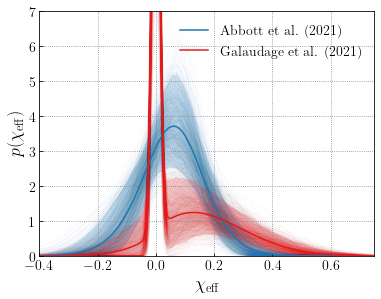

In [6]:
fig,ax = plt.subplots()

ax.plot(chi_grid,p_chi_gaussian.T,color='#1f78b4',lw=0.1,alpha=0.1,zorder=-1)
ax.plot(chi_grid,np.mean(p_chi_gaussian,axis=0),color='#1f78b4',label=r'Abbott et al. (2021)')
ax.fill_between(chi_grid,np.quantile(p_chi_gaussian,0.05,axis=0),np.quantile(p_chi_gaussian,0.95,axis=0),
                facecolor='#1f78b4',lw=None,alpha=0.2)

ax.plot(chi_grid,p_chi_eff_galaudage.T,color='#e31a1c',lw=0.1,alpha=0.1,zorder=-1)
ax.plot(chi_grid,np.mean(p_chi_eff_galaudage,axis=0),color='#e31a1c',lw=1.5,label=r'Galaudage et al. (2021)')
ax.fill_between(chi_grid,np.quantile(p_chi_eff_galaudage,0.05,axis=0),np.quantile(p_chi_eff_galaudage,0.95,axis=0),
                facecolor='#e31a1c',lw=None,alpha=0.2)
    
ax.set_ylim(0,7)
ax.set_xlim(-0.4,0.75)
ax.set_rasterization_zorder(0)
ax.set_xlabel(r'$\chi_\mathrm{eff}$')
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$')
ax.legend(loc='upper right',frameon=False,fontsize=14)

plt.savefig('figure_02.pdf',dpi=200)
plt.show()